**About Book Crossing Dataset**<br>

This dataset has been compiled by Cai-Nicolas Ziegler in 2004, and it comprises of three tables for users, books and ratings. Explicit ratings are expressed on a scale from 1-10 (higher values denoting higher appreciation) and implicit rating is expressed by 0.

Reference: http://www2.informatik.uni-freiburg.de/~cziegler/BX/ 

**Objective**

This project entails building a Book Recommender System for users based on user-based and item-based collaborative filtering approaches.

#### Execute the below cell to load the datasets

In [1]:
#Import all the necessary modules
import pandas as pd
import numpy as np
from scipy import stats
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sparsesvd import sparsesvd
from scipy.sparse import csc_matrix

%matplotlib inline

In [2]:
#Loading data
books = pd.read_csv("books.csv", sep=";", error_bad_lines=False, encoding="latin-1")
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']

users = pd.read_csv('users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
users.columns = ['userID', 'Location', 'Age']

ratings = pd.read_csv('ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
ratings.columns = ['userID', 'ISBN', 'bookRating']

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
C:\AIML\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785:

### Check no.of records and features given in each dataset

In [3]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
ISBN                 271360 non-null object
bookTitle            271360 non-null object
bookAuthor           271359 non-null object
yearOfPublication    271360 non-null object
publisher            271358 non-null object
imageUrlS            271360 non-null object
imageUrlM            271360 non-null object
imageUrlL            271357 non-null object
dtypes: object(8)
memory usage: 16.6+ MB


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
userID      278858 non-null int64
Location    278858 non-null object
Age         168096 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [5]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
userID        1149780 non-null int64
ISBN          1149780 non-null object
bookRating    1149780 non-null int64
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


## Exploring books dataset

In [6]:
books.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


### Drop last three columns containing image URLs which will not be required for analysis

In [7]:
books.drop(['imageUrlS','imageUrlM','imageUrlL'], axis=1, inplace=True)

In [8]:
books.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


**yearOfPublication**

### Check unique values of yearOfPublication


In [9]:
books.yearOfPublication.unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

As it can be seen from above that there are some incorrect entries in this field. It looks like Publisher names 'DK Publishing Inc' and 'Gallimard' have been incorrectly loaded as yearOfPublication in dataset due to some errors in csv file.


Also some of the entries are strings and same years have been entered as numbers in some places. We will try to fix these things in the coming questions.

### Check the rows having 'DK Publishing Inc' as yearOfPublication

In [10]:
books[(books.yearOfPublication == 'DK Publishing Inc') | (books.yearOfPublication == 'Gallimard')]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...


### Drop the rows having `'DK Publishing Inc'` and `'Gallimard'` as `yearOfPublication`

In [11]:
books = books.drop([209538,221678,220731])

### Change the datatype of yearOfPublication to 'int'

In [12]:
books.yearOfPublication = books.yearOfPublication.astype('int32')

In [13]:
books.dtypes

ISBN                 object
bookTitle            object
bookAuthor           object
yearOfPublication     int32
publisher            object
dtype: object

### Drop NaNs in `'publisher'` column


In [14]:
books.publisher.dropna(inplace=True)

## Exploring Users dataset

In [15]:
print(users.shape)
users.head()

(278858, 3)


,userID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


### Get all unique values in ascending order for column `Age`

In [16]:
np.sort(users.Age.unique())

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 113., 114., 115., 116., 118., 119., 123., 124., 127.,
       128., 132., 133., 136., 137., 138., 140., 141., 143., 146., 147.,
       148., 151., 152., 156., 157., 159., 162., 168., 172., 175., 183.,
       186., 189., 199., 200., 201., 204., 207., 20

Age column has some invalid entries like nan, 0 and very high values like 100 and above

### Values below 5 and above 90 do not make much sense for our book rating case...hence replace these by NaNs

In [17]:
indexary = users[(users.Age > 90) | (users.Age < 5)].index
for i in indexary:
    users.loc[i,['Age']] = np.nan

### Replace null values in column `Age` with mean

In [18]:
np.sort(users.Age.unique())

array([ 5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17.,
       18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28., 29., 30.,
       31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42., 43.,
       44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55., 56.,
       57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69.,
       70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81., 82.,
       83., 84., 85., 86., 87., 88., 89., 90., nan])

In [19]:
agemean = int(np.mean(users.Age))
users['Age'] = users['Age'].replace(np.nan, agemean)

In [20]:
np.sort(users.Age.unique())

array([ 5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17.,
       18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28., 29., 30.,
       31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42., 43.,
       44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55., 56.,
       57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69.,
       70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81., 82.,
       83., 84., 85., 86., 87., 88., 89., 90.])

### Change the datatype of `Age` to `int`

In [21]:
users.Age = users.Age.astype('int32')

In [22]:
print(sorted(users.Age.unique()))

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90]


## Exploring the Ratings Dataset

### check the shape

In [23]:
ratings.shape

(1149780, 3)

In [24]:
n_users = users.shape[0]
n_books = books.shape[0]

In [25]:
ratings.head(5)

,userID,ISBN,bookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


### Ratings dataset should have books only which exist in our books dataset. Drop the remaining rows

In [26]:
isbns_bks = set(books.ISBN.unique())
isbns_rtngs = set(ratings.ISBN.unique())
diff = list(isbns_rtngs.difference(isbns_bks))

In [27]:
print('Before:',ratings.shape)
ratings.drop(ratings[ratings.ISBN.isin(diff) == True].index, inplace=True)
print('After',ratings.shape)

Before: (1149780, 3)
After (1031132, 3)


### Ratings dataset should have ratings from users which exist in users dataset. Drop the remaining rows

In [28]:
#userID
users_id = set(users.userID.unique())
ratings_userid = set(ratings.userID.unique())
diff_userids = list(ratings_userid.difference(users_id))
diff_userids
# All the user ids of ratings data are present in users data

[]

### Consider only ratings from 1-10 and leave 0s in column `bookRating`

In [29]:
ratings.groupby('bookRating').count()
# Looks like most records are not rated ('0')

,userID,ISBN
bookRating,,
0,647291,647291
1,1481,1481
2,2375,2375
3,5118,5118
4,7617,7617
5,45355,45355
6,31687,31687
7,66401,66401
8,91804,91804


In [30]:
# removing unrated records
ratings_1_10 = ratings[ratings.bookRating > 0]

### Find out which rating has been given highest number of times

In [31]:
ratings_1_10.groupby('bookRating').count()

,userID,ISBN
bookRating,,
1,1481,1481
2,2375,2375
3,5118,5118
4,7617,7617
5,45355,45355
6,31687,31687
7,66401,66401
8,91804,91804
9,60778,60778


In [32]:
#From the list, we can see rating '8' is given more number of times

### **Collaborative Filtering Based Recommendation Systems**

### For more accurate results only consider users who have rated atleast 100 books

In [33]:
users_grp = ratings_1_10.groupby('userID').count() > 100
users_grp_ids = users_grp[users_grp.ISBN == True].index

In [34]:
users_rated_100 = pd.DataFrame(columns=['userID','Location','Age'])
ratings_100 = pd.DataFrame(columns=['userID','ISBN','bookRating'])

for userid in users_grp_ids:
    temp = users[users.userID == userid]
    user_obj = {'userID':temp['userID'].values[0],'Location':temp['Location'].values[0],'Age':temp['Age'].values[0]}
    users_rated_100 = users_rated_100.append(user_obj,ignore_index=True)
    #ratings
    temp_r = ratings_1_10[ratings_1_10.userID == userid]
    rtng_obj = {'userID':temp_r['userID'].values[0],'ISBN':temp_r['ISBN'].values[0],'bookRating':temp_r['bookRating'].values[0]}
    ratings_100 = ratings_100.append(rtng_obj,ignore_index=True)
users_rated_100.head()

,userID,Location,Age
0,2033,"omaha, nebraska, usa",27
1,2110,"charlotte, north carolina, usa",34
2,2276,"niskayuna, new york, usa",46
3,4017,"new orleans, louisiana, usa",48
4,4385,"albq, new mexico, usa",33


In [35]:
ratings_1_10[ratings_1_10.userID == 2033].count()

userID        129
ISBN          129
bookRating    129
dtype: int64

### Generating ratings matrix from explicit ratings


#### Note: since NaNs cannot be handled by training algorithms, replace these by 0, which indicates absence of ratings

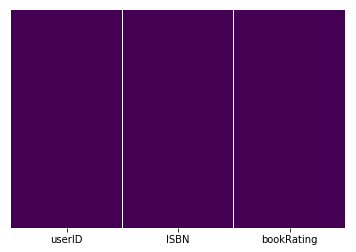

In [36]:
sns.heatmap(ratings == np.nan,yticklabels=False,cbar=False,cmap='viridis')
# There are no NaN is ratings dataset and we have already taken into account only ratings from 1 and 10 

### Generate the predicted ratings using SVD with no.of singular values to be 50

In [37]:
ratings_100.head()
ratings_100.userID = ratings_100.userID.astype('int32')

In [38]:
ratings_100.shape
R_df = ratings_100.pivot(index = 'userID', columns ='ISBN', values = 'bookRating').fillna(0)
R_df.head(5)

ISBN,0000913154,0001046438,000104799X,0001048082,0001053736,0001055607,0001056107,0001845039,0001935968,0001944711,...,0263785459,0312979681,0373028644,0373037805,037307669X,068140969X,0684803534,2013219466,8401013305,8401461812
userID,,,,,,,,,,,,,,,,,,,,,
2033,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2110,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2276,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4017,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4385,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
R_df.shape
# This is the User Rating Matrix - URM

(440, 379)

In [40]:
#constants defining the dimensions of our User Rating Matrix (URM) 
MAX_PID = 379
MAX_UID = 440

#Compute SVD of the user ratings matrix 
def computeSVD(urm, K):     
    U, s, Vt = sparsesvd(urm, K)      
    dim = (len(s), len(s))     
    S = np.zeros(dim, dtype=np.float32)     
    for i in range(0, len(s)):         
        S[i,i] = np.sqrt(s[i])      
        U = csc_matrix(np.transpose(U), dtype=np.float32)     
        S = csc_matrix(S, dtype=np.float32)     
        Vt = csc_matrix(Vt, dtype=np.float32)          
        return U, S, Vt

#Compute estimated rating for the test user
def computeEstimatedRatings(urm, U, S, Vt, uTest, K, test):
    rightTerm = S*Vt
    estimatedRatings = np.zeros(shape=(MAX_UID, MAX_PID), dtype=np.float16)
    for userTest in uTest:
        prod = U[userTest, :]*rightTerm
        #we convert the vector to dense format in order to get the     
        #indices of the movies with the best estimated ratings 
        estimatedRatings[userTest, :] = prod.todense()
        recom = (-estimatedRatings[userTest, :]).argsort()[:379]
    return recom

In [41]:
R_df.values

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [42]:
#Used in SVD calculation (number of latent factors)
K=50
#Initialize a sample user rating matrix
urm = R_df.values 
urm = csc_matrix(urm, dtype=np.float32)
#Compute SVD of the input user ratings matrix
U, S, Vt = computeSVD(urm, K)

### Take a particular user_id

### Lets find the recommendations for user with id `2110`

#### Note: Execute the below cells to get the variables loaded

In [43]:
test_user_id = 2110
user_id_index = users_rated_100[users_rated_100.userID == test_user_id].index[0]+1
#2nd row in ratings matrix and predicted matrix

### Get the predicted ratings for userID `2110` and sort them in descending order

In [44]:
uTest = [user_id_index]
print("User id for whom recommendations are needed: %d" % test_user_id)
#Get estimated rating for test user
print("Predictied ratings:")
uTest_recommended_items = computeEstimatedRatings(urm, U, S, Vt, uTest, K, True)
print(uTest_recommended_items)

User id for whom recommendations are needed: 2110
Predictied ratings:
[  0 257 256 255 254 253 252 251 250 249 248 247 246 245 244 243 242 241
 240 239 258 259 260 261 281 280 279 278 277 276 275 274 273 238 272 270
 269 268 267 266 265 264 263 262 271 237 236 235 210 209 208 207 206 205
 204 203 202 211 201 199 198 197 196 195 194 193 192 191 200 282 212 214
 234 233 232 231 230 229 228 227 226 213 225 223 222 221 220 219 218 217
 216 215 224 190 283 285 352 351 350 349 348 347 346 345 344 343 342 341
 340 339 338 337 336 335 334 353 354 355 356 376 375 374 373 372 371 370
 369 368 333 367 365 364 363 362 361 360 359 358 357 366 332 331 330 305
 304 303 302 301 300 299 298 297 306 296 294 293 292 291 290 289 288 287
 286 295 284 307 309 329 328 327 326 325 324 323 322 321 308 320 318 317
 316 315 314 313 312 311 310 319 377 189 187  67  66  65  64  63  62  61
  60  59  58  57  56  55  54  53  52  51  50  49  68  69  70  71  91  90
  89  88  87  86  85  84  83  48  82  80  79  78  77  

In [45]:
uTest_recommended_items.size

379

In [46]:
user2110_predictions = pd.DataFrame(columns=['isbn','rating'])
cnt = 0
for isbn in R_df.columns:
    rtng_obj = {'isbn':isbn,'rating':uTest_recommended_items[cnt]}
    user2110_predictions = user2110_predictions.append(rtng_obj,ignore_index=True)
    cnt = cnt+1

In [47]:
user2110_predictions.sort_values(by=['rating'], ascending=False)

,isbn,rating
378,8401461812,378
188,0028639960,377
119,0020413904,376
120,0020415133,375
121,0020427018,374
122,0020427107,373
123,0020427115,372
124,0020427751,371
125,0020427859,370
126,0020442009,369


### Create a dataframe with name `user_data` containing userID `2110` explicitly interacted books

In [48]:
user_data = ratings_1_10[ratings_1_10.userID == 2110]

In [49]:
user_data.head()

,userID,ISBN,bookRating
14448,2110,0060987529,7
14449,2110,0064472779,8
14450,2110,0140022651,10
14452,2110,0142302163,8
14453,2110,0151008116,5


In [50]:
user_data.shape

(103, 3)

### Combine the user_data and and corresponding book data(`book_data`) in a single dataframe with name `user_full_info`

In [51]:
user2110_full_info = pd.merge(user_data, books.drop_duplicates(['ISBN']), on="ISBN", how="left")
user2110_full_info.head()

,userID,ISBN,bookRating,bookTitle,bookAuthor,yearOfPublication,publisher
0,2110,0060987529,7,Confessions of an Ugly Stepsister : A Novel,Gregory Maguire,2000,Regan Books
1,2110,0064472779,8,All-American Girl,Meg Cabot,2003,HarperTrophy
2,2110,0140022651,10,Journey to the Center of the Earth,Jules Verne,1965,Penguin Books
3,2110,0142302163,8,The Ghost Sitter,Peni R. Griffin,2002,Puffin Books
4,2110,0151008116,5,Life of Pi,Yann Martel,2002,Harcourt


In [52]:
user2110_full_info.shape

(103, 7)

In [53]:
user_full_info = pd.merge(ratings_1_10, books.drop_duplicates(['ISBN']), on="ISBN", how="left")
user_full_info.shape

(383841, 7)

In [54]:
user_full_info[user_full_info.userID == 2110].head()

,userID,ISBN,bookRating,bookTitle,bookAuthor,yearOfPublication,publisher
4247,2110,0060987529,7,Confessions of an Ugly Stepsister : A Novel,Gregory Maguire,2000,Regan Books
4248,2110,0064472779,8,All-American Girl,Meg Cabot,2003,HarperTrophy
4249,2110,0140022651,10,Journey to the Center of the Earth,Jules Verne,1965,Penguin Books
4250,2110,0142302163,8,The Ghost Sitter,Peni R. Griffin,2002,Puffin Books
4251,2110,0151008116,5,Life of Pi,Yann Martel,2002,Harcourt


### Get top 10 recommendations for above given userID from the books not already rated by that user

In [55]:
subset_df = user_full_info.head(10000)
train_data, test_data = model_selection.train_test_split(subset_df, test_size = 0.20, random_state=0)

In [56]:
user_id = 2110

In [57]:
user_data = train_data[train_data['userID'] == user_id]
user_items = list(user_data['ISBN'].unique())
print("No. of unique books for the user: %d" % len(user_items))
all_books = list(train_data['ISBN'].unique())
print("no. of unique books in the training set: %d" % len(all_books))

No. of unique books for the user: 74
no. of unique books in the training set: 6832


In [58]:
#cooccurence_matrix = self.construct_cooccurence_matrix(user_books, all_books)

def get_item_users(train_data, item):
    item_data = train_data[train_data['ISBN'] == item]
    item_users = set(item_data['userID'].unique())
    return item_users

user_books_users = []
for i in range(0, len(user_items)):
    user_books_users.append(get_item_users(train_data, user_items[i]))
        
cooccurence_matrix = np.matrix(np.zeros(shape=(len(user_items), len(all_books))), float)
for i in range(0,len(all_books)):
    books_i_data = train_data[train_data['ISBN'] == all_books[i]]
    users_i = set(books_i_data['userID'].unique())
            
    for j in range(0,len(user_items)):
        users_j = user_books_users[j]
        users_intersection = users_i.intersection(users_j)
        if (len(users_intersection) != 0):
            users_union = users_i.union(users_j)                    
            cooccurence_matrix[j,i] = float(len(users_intersection))/float(len(users_union))
        else:
            cooccurence_matrix[j,i] = 0

In [59]:
def generate_top_recommendations(train_data, user, cooccurence_matrix, all_books, user_books):
        print("Non zero values in cooccurence_matrix :%d" % np.count_nonzero(cooccurence_matrix))
        
        #Calculate a weighted average of the scores in cooccurence matrix for all user books.
        user_sim_scores = cooccurence_matrix.sum(axis=0)/float(cooccurence_matrix.shape[0])
        user_sim_scores = np.array(user_sim_scores)[0].tolist()
 
        #Sort the indices of user_sim_scores based upon their value
        #Also maintain the corresponding score
        sort_index = sorted(((e,i) for i,e in enumerate(list(user_sim_scores))), reverse=True)
    
        #Create a dataframe from the following
        columns = ['user_id', 'book', 'score', 'rank']
        #index = np.arange(1) # array of numbers for the number of samples
        df = pd.DataFrame(columns=columns)
         
        #Fill the dataframe with top 10 item based recommendations
        rank = 1 
        for i in range(0,len(sort_index)):
            if ~np.isnan(sort_index[i][0]) and all_books[sort_index[i][1]] not in user_books and rank <= 10:
                df.loc[len(df)]=[user,all_books[sort_index[i][1]],sort_index[i][0],rank]
                rank = rank+1
        
        #Handle the case where there are no recommendations
        if df.shape[0] == 0:
            print("The current user has no books for training the item similarity based recommendation model.")
            return -1
        else:
            return df

In [60]:
#cooccurence_matrix
df_recommendations = generate_top_recommendations(train_data, user_id, cooccurence_matrix, all_books, user_items)

Non zero values in cooccurence_matrix :5576


In [61]:
df_recommendations

,user_id,book,score,rank
0,2110,0590629816,0.013514,1
1,2110,0590629786,0.013514,2
2,2110,0399143335,0.006757,3
3,2110,0689832877,0.006757,4
4,2110,0385314744,0.006757,5
5,2110,1574533525,0.006757,6
6,2110,0836270320,0.006757,7
7,2110,0440415993,0.006757,8
8,2110,0061093106,0.006757,9
9,2110,0385499825,0.006757,10
